# Word Meaning Prediction - CBOW model self-implementation

In [100]:
import re
import nltk
import emoji
import numpy as np
from nltk.tokenize import word_tokenize
from matplotlib import pyplot

## Word Embeddings

- If we represent each word with an integer. There is very few semantic meaning.
- - why happy(1)< zebra(316) ?
- If we represent each word as hot-encodings.
- - Each word will contain as many columns as vocabulary length. Which will create sparse matrices and still do not imply relationships between words. Always same distance bw any 2 words.
- So Word Embeddings solve this challenge.
- - By adding columns with values between 0 and 1 depending on the meaning of the word.
- - They carry the meaning.
- - Reduce the dimensions.

##### For Word Embeddings we need
1. Corpus : Contains words we want to embed, organized in the same way as they would be in the context of interest.
- General-purpose: Wikipedia.
- Specialized: Contracts, law books, Genes ...


In [102]:
from utils.nlp import MyNLTKLoader, get_dict, sigmoid, get_vectors, get_batches, compute_pca

text_path = "../DATA/common_narration.txt"

TextLoader = MyNLTKLoader(text_path, "english")

list_of_list_of_words = TextLoader(sentences = True,
                                   tokenizing=True, 
                                   information = True)



all_words = [word for sentence in list_of_list_of_words for word in sentence]

word2Ind, Ind2word = get_dict(all_words)

V = len(word2Ind)

# Compute the frequency distribution of the words in the dataset (vocabulary)\n",
fdist = nltk.FreqDist(word for word in all_words)

print("Size of vocabulary: ",V)
print("Most frequent tokens: ",fdist.most_common(20))


Size of vocabulary:  8735
Most frequent tokens:  [('the', 3098), ('a', 1254), ('i', 1136), ('was', 629), ('you', 619), ('his', 601), ('is', 582), ('he', 537), ('it', 516), ('said', 486), ('upon', 466), ('to', 465), ('holmes', 463), ('my', 451), ('have', 414), ('one', 370), ('that', 365), ('would', 327), ('in', 324), ('had', 321)]


In [104]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

In [105]:
N = 100 # Embedding Dimension

model = Sequential()
model.add(
    Input(shape=(V,))
)
model.add(
    Dense(V, activation='relu')
)
model.add(
    Dense(V, activation='softmax')
)


In [106]:
model.compile(
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

In [107]:
def get_windows(words, C):
    """
    Outputs word, C prev words and C next words.
    """
    i = C
    windows = []
    while i < len(words) - C:
        center_word = words[i]
        context_words = words[(i - C):i] + words[(i+1):(i+C+1)]
        windows.append([center_word, context_words])
        i += 1
    return windows

# Define the 'word_to_one_hot_vector' function as seen in a previous notebook
def word_to_one_hot_vector(word, word2Ind, V):
    one_hot_vector = np.zeros(V)
    one_hot_vector[word2Ind[word]] = 1
    return one_hot_vector

# Define the 'context_words_to_vector' function as seen in a previous notebook
def context_words_to_vector(context_words, word2Ind, V):
    context_words_vectors = [word_to_one_hot_vector(w, word2Ind, V) for w in context_words]
    context_words_vectors = np.mean(context_words_vectors, axis=0)
    return context_words_vectors

In [108]:
C = 2
windows = get_windows(all_words,C)

one_hot_vector_words = []
meaning_context_words = []
for window in windows:
    meaning_context_words.append(context_words_to_vector(window[1], word2Ind, V))
    one_hot_vector_words.append(word_to_one_hot_vector(window[0], word2Ind, V))

In [109]:
X = np.array(meaning_context_words)
Y = np.array(one_hot_vector_words)

In [111]:
BATCH_SIZE = 128

## TRAINING THE MODEL:
print(f"Training...")
r = model.fit(
    X,
    Y,
    batch_size = BATCH_SIZE,
    epochs = 5,
    validation_split = 0.2
)

Training...
Epoch 1/5
423/423 [==============================] - 222s 523ms/step - loss: 7.3888 - accuracy: 0.0503 - val_loss: 7.5300 - val_accuracy: 0.0480
Epoch 2/5
423/423 [==============================] - 221s 521ms/step - loss: 6.9076 - accuracy: 0.0609 - val_loss: 7.4759 - val_accuracy: 0.0523
Epoch 3/5
423/423 [==============================] - 218s 515ms/step - loss: 6.4359 - accuracy: 0.0744 - val_loss: 7.3894 - val_accuracy: 0.0567
Epoch 4/5
423/423 [==============================] - 220s 518ms/step - loss: 5.8561 - accuracy: 0.1051 - val_loss: 7.3998 - val_accuracy: 0.0589
Epoch 5/5
423/423 [==============================] - 219s 517ms/step - loss: 5.1188 - accuracy: 0.1786 - val_loss: 7.5347 - val_accuracy: 0.0550


In [113]:
# W1 = Column per word in Vocab. Same order as in the input words.  
W1 = model.layers[0].get_weights()
Weights1 = W1[0]
Biases_w1 = W1[1]

# W2 = Has V rows. Each Row = Word in Vocab. Same order!
W2 = model.layers[1].get_weights()
Weights2 = W2[0]
Biases_w2 = W2[1]

In [114]:
## WORDS_EMBEDDINGS
words_embeddings_trained = Weights1 + Weights2 / 2

In [116]:
words = ['king', 'queen','lord','man', 'woman','dog',
         'rich','happy','sad']

# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = words_embeddings_trained[idx, :]
print(X.shape, idx)  # X.shape:  Number of words of dimension N eac

(9, 8735) [4388, 6076, 4686, 4781, 8615, 2376, 6421, 3675, 6544]


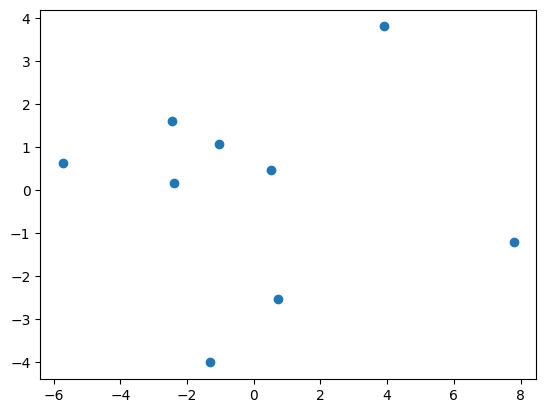

In [117]:
result= compute_pca(X, 2)

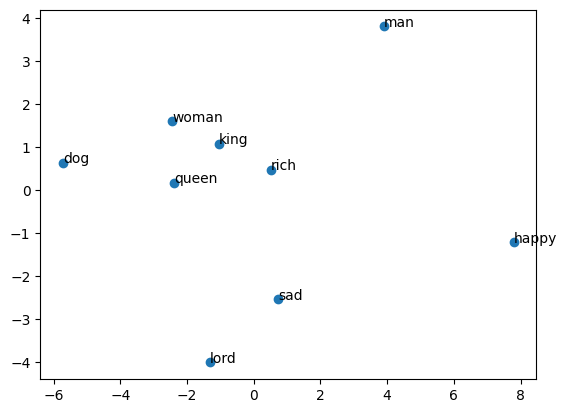

In [119]:
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

2. Embedding Method - ML Model - Self Supervised Learning
- Self Supervised Learning is a mix. Unsupervised, since the corpus is unlabeled. But supervised because the data itself provides the necessary context which would ordinarily make up the labels.
- Hyperparameters: Dimension of the word embedding vectors. Higher dimensions capture more meaning, but makes it computationally expensive. Usually D{300-2k}

##### Examples:
- word2vec: Continuous bag-of-words.
- - Logic behind: If two unique words are freq surranded by similar words in various sentences, then they tend to be related in their meaning. Related semantically.

- fastText: Continuous skip-gram. Based on representing words as n-grams of characters. It supports Out-Of-Vocabulary words.
- BERT / ELMo / GPT-2 : Words may have different embeddings depending on their context. It supports words with similar meanings, or different words with same meaning.

##### Word Prediction Model - CBOW model
Using a Continuous bag-of-words Model
- Ex:
I am happy because I am learning

- Center word: happy. The word to predict.
- Context words: I am ___ because I
- C = 2. (2 words before or after. Size of context.)
- window: I am happy because I
- W: window size = 5.
- Next window will be: am happy ___ I am. where center word = because.

##### Architecture - Feed Forward Network - 1D
- x (Context words vector)
- Input Layer (Vocab dim) + ReLU (ReLU only let positive num pass through)
- - z1 = W1(NxV) * x(Vx1) + b(Nx1) = z1(Nx1) 
- Hiden Layer with N word_embedding dim - A neuron per dim. + Softmax
- Output Layer (Vocab dim)
- _y (Highest probable center word vector)
<img src = "../figures/cbow_arch.png">


##### Architecture CBOW 2D
- We can get the output of several cases, not only 1.
- Different word-centers. Substitute 1 by m.

#### Cost Function - Cross-Entropy (2 classes, pred-exp)
- We need to predict 1 of the V possible words.
- Minimize the cost function by adjusting the parameters (W1, b1 and W2 b2)
- The LOSS is larger, when the prediction is incorrect.
- Exp [0, 0, 1, 0]
- Pred [0.1, 0.1, 0.7,0.1]
- Since the 3rd word is expected to be correct (1), if Pred[3] is the higher number: 
- - 0 * log(0.1)
- - 0 * log(0.1)
- - 1 * log(0.7)
- - 0 * log(0.1)
- - = LOW LOSS.

## TRAINING
1. Forward Propagation

2. Cost

3. Backpropagation with Gradient Descent